In [ ]:
import numpy as np
import pandas as pd
import scipy.optimize as opt
import matplotlib.pyplot as plt
import seaborn as sns
# %matplotlib inline

In [ ]:
def ll4(x,b,c,d,e):
    '''This function is basically a copy of the LL.4 function from the R drc package with
     - b: hill slope
     - c: min response
     - d: max response
     - e: EC50'''
    return (c+(d-c)/(1+np.exp(b*(np.log(x)-np.log(e)))))

def pDose(x):
    '''This is just a helper function, to compute easily log transformed concentrations used in drug discovery'''
    return(-np.log10(1e-6*x))

### Generating data

In [145]:
params = [
    { 'compound': 'diltiazem',  'b': 0.714205489,    'c': 0,   'd': 100,  'e': 112.1303862,   'startDose': 12500,  'nDose': 8,  'dilution': 3 },
    # { 'compound': 'A',  'b': 1,    'c': 0,   'd': 100,  'e': 0.4,   'startDose': 10,  'nDose': 8,  'dilution': 3 },
    # { 'compound': 'B',  'b': 0.7,  'c': 0,   'd': 86,   'e': 1.3,   'startDose': 30,  'nDose': 8,  'dilution': 3 },
    # { 'compound': 'C',  'b': 2,    'c': 24,  'd': 152,  'e': 0.02,  'startDose': 3,   'nDose': 8,  'dilution': 3 }
]

In [146]:
drData=[]
for curve in params:        
    # generate base curve
    curData = pd.DataFrame(
        data={
            'compound':curve['compound'], 
            'dose':curve['startDose']/np.power(curve['dilution'], range(curve['nDose']))
        }
    )    
    curData['logDose'] = pDose(curData.dose)
    curData['response'] = curData.dose.apply(lambda x: ll4(x,*[curve[i] for i in ['b','c','d','e']]))        
    
    # generate replicates
    repData = []
    for i in range(5):
        rep = curData        
        rep.response += 0.25*np.random.normal(len(rep.response))
        repData.append(rep.copy())    
    repData = pd.concat(repData)    
    drData.append(repData)    
# assemble data
drData = pd.concat(drData)

drData.head()

,compound,dose,logDose,response
0,diltiazem,12500.000000,1.903090,5.493475
1,diltiazem,4166.666667,2.380211,9.188593
2,diltiazem,1388.888889,2.857332,16.375202
3,diltiazem,462.962963,3.334454,28.802564
4,diltiazem,154.320988,3.811575,46.480177


In [147]:
compoundData = drData.groupby(['compound'])
fitData = []
for name,group in compoundData:
    fitCoefs, covMatrix = opt.curve_fit(ll4, group.dose, group.response)
    resids = group.response-group.dose.apply(lambda x: ll4(x,*fitCoefs))
    curFit = dict(zip(['b','c','d','e'],fitCoefs))
    curFit['compound']=name
    curFit['residuals']=sum(resids**2)
    fitData.append(curFit)
fitCompound = [ item['compound'] for item in fitData]
fitCompound

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log
  import sys


['diltiazem']

In [148]:
fitTable = pd.DataFrame(fitData).set_index('compound')
fitTable

,b,c,d,e,residuals
compound,,,,,
diltiazem,0.714205,6.498794,106.498794,112.130386,364.424127


In [149]:
fitTable = pd.DataFrame(fitData).set_index('compound')
paramTable = pd.DataFrame(params).set_index('compound')[['b','c','d','e']]
paramTable.columns = ['ref_'+i for i in paramTable.columns]
fitTable.join(paramTable)

,b,c,d,e,residuals,ref_b,ref_c,ref_d,ref_e
compound,,,,,,,,,
diltiazem,0.714205,6.498794,106.498794,112.130386,364.424127,0.714205,0,100,112.130386


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


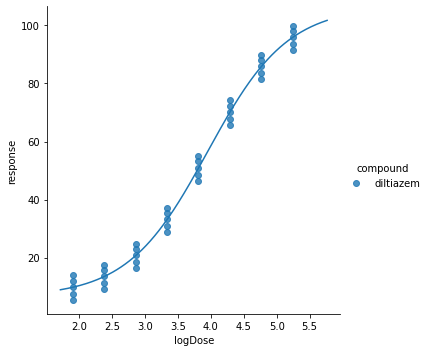

In [150]:
refDose = np.linspace(min(drData.logDose)*0.9,max(drData.logDose)*1.1,256)
refDose = (10**-refDose)*1e6
sns.lmplot('logDose','response',data=drData,hue='compound',fit_reg=False)
for fit in fitData:
    plt.plot([pDose(i) for i in refDose], [ll4(i,*[fit[i] for i in ['b','c','d','e']]) for i in refDose])